In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import tensorflow as tf
import meshplot as mp
import gudhi                 as gd
from tqdm                    import tqdm
from gudhi.tensorflow        import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer
from pyvis.network import Network
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, KMeans
import itertools
import networkx as nx

## Mapper code

In [40]:
def to_hex(color):
    return '#'+''.join(["%02x" % e for e in color])

class MapperComplex(BaseEstimator, TransformerMixin):
    """
    This is a class for computing Mapper simplicial complexes on point clouds or distance matrices.
    """
    def __init__(self, input_type="point cloud", colors=None, mask=0,
                       filters=None, filter_bnds=None, resolutions=None, gains=None, clustering=DBSCAN()):
        """
        Constructor for the MapperComplex class.

        Parameters:
            input_type (string): type of input data. Either "point cloud" or "distance matrix".
            colors (numpy array of shape (num_points) x (num_colors)): functions used to color the 
                nodes of the cover complex. More specifically, coloring is done by computing the 
                means of these functions on the subpopulations corresponding to each node. 
            mask (int): threshold on the size of the cover complex nodes (default 0). Any node 
                associated to a subpopulation with less than **mask** points will be removed.
            filters (numpy array of shape (num_points) x (num_filters)): filter functions 
                (sometimes called lenses) used to compute the cover. Each column of the numpy array 
                defines a scalar function defined on the input points.
            filter_bnds (numpy array of shape (num_filters) x 2): limits of each filter, of the 
                form [[f_1^min, f_1^max], ..., [f_n^min, f_n^max]]. If one of the values is numpy.nan, 
                it can be computed from the dataset with the fit() method.
            resolutions (numpy array of shape num_filters containing integers): resolution of 
                each filter function, ie number of intervals required to cover each filter image.
            gains (numpy array of shape num_filters containing doubles in [0,1]): gain of 
                each filter function, ie overlap percentage of the intervals covering each filter image.
            clustering (class): clustering class (default sklearn.cluster.DBSCAN()). Common 
                clustering classes can be found in the scikit-learn library (such as 
                AgglomerativeClustering for instance).
        """
        self.filters, self.filter_bnds, self.resolutions = filters, filter_bnds, resolutions
        self.gains, self.colors, self.clustering = gains, colors, clustering
        self.input_type, self.mask = input_type, mask
    
    def get_networkx(self, get_attrs=False):
        """
        Turn the 1-skeleton of the cover complex computed after calling fit() method into a networkx graph.
        This function requires networkx (https://networkx.org/documentation/stable/install.html).

        Parameters:
            get_attrs (bool): if True, the color functions will be used as attributes for the networkx graph.

        Returns:
            G (networkx graph): graph representing the 1-skeleton of the cover complex.
        """
        st = self.simplex_tree
        G = nx.Graph()
        for (splx,_) in st.get_skeleton(1):
            if len(splx) == 1:
                G.add_node(splx[0])
            if len(splx) == 2:
                G.add_edge(splx[0], splx[1])
        if get_attrs:
            c_vals=[float(node['colors']) for node in self.node_info.values()]
            norm = mpl.colors.Normalize(vmin=np.min(c_vals), vmax=np.max(c_vals))
            cmap = cm.viridis
            m = cm.ScalarMappable(norm=norm,  cmap=cmap)
            attrs = {k: {"color": to_hex(m.to_rgba(float(self.node_info[k]["colors"])
                                                   ,bytes=True)[0:3])} for k in G.nodes()}
            nx.set_node_attributes(G, attrs)
        return G

    def fit(self, X, y=None):
        """
        Fit the MapperComplex class on a point cloud or a distance matrix: compute the Mapper complex 
        and store it in a simplex tree called simplex_tree.

        Parameters:
            X (numpy array of shape (num_points) x (num_coordinates) 
            if point cloud and (num_points) x (num_points) if distance matrix): input point 
            cloud or distance matrix.
            y (n x 1 array): point labels (unused).
        """

        num_pts, num_filters = self.filters.shape[0], self.filters.shape[1]

        # If some filter limits are unspecified, automatically compute them
        if self.filter_bnds is None:
            self.filter_bnds = np.hstack([np.min(self.filters, axis=0)[:,np.newaxis], 
                                          np.max(self.filters, axis=0)[:,np.newaxis]])

        # Initialize attributes
        self.simplex_tree, self.node_info = gd.SimplexTree(), {}

        if np.all(self.gains < .5):

            # Compute which points fall in which patch or patch intersections
            interval_inds, intersec_inds = np.empty(self.filters.shape), np.empty(self.filters.shape)
            for i in range(num_filters):
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                intersec_endpoints = []
                for j in range(1, len(interval_endpoints)-1):
                    intersec_endpoints.append(interval_endpoints[j] - g*l / (2 - 2*g))
                    intersec_endpoints.append(interval_endpoints[j] + g*l / (2 - 2*g))
                interval_inds[:,i] = np.digitize(f, interval_endpoints)
                intersec_inds[:,i] = 0.5 * (np.digitize(f, intersec_endpoints) + 1)

            # Build the binned_data map that takes a patch or a patch intersection 
            # and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    a, b = interval_inds[i,j], intersec_inds[i,j]
                    list_preimage.append([a])
                    if b == a:
                        list_preimage[j].append(a+1)
                    if b == a-1:
                        list_preimage[j].append(a-1)
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        else:

            # Compute interval endpoints for each filter
            l_int, r_int = [], []
            for i in range(num_filters):
                L, R = [], []
                f, r, g = self.filters[:,i], self.resolutions[i], self.gains[i]
                min_f, max_f = self.filter_bnds[i,0], np.nextafter(self.filter_bnds[i,1], np.inf)
                interval_endpoints, l = np.linspace(min_f, max_f, num=r+1, retstep=True)
                for j in range(len(interval_endpoints)-1):
                    L.append(interval_endpoints[j]   - g*l / (2 - 2*g))
                    R.append(interval_endpoints[j+1] + g*l / (2 - 2*g))
                l_int.append(L)
                r_int.append(R)

            # Build the binned_data map that takes a patch or a patch intersection 
            # and outputs the indices of the points contained in it
            binned_data = {}
            for i in range(num_pts):
                list_preimage = []
                for j in range(num_filters):
                    fval = self.filters[i,j]
                    start = int(min(np.argwhere(np.array(r_int[j]) >= fval)))
                    end = int(max(np.argwhere(np.array(l_int[j]) <= fval)))
                    list_preimage.append(list(range(start, end+1)))
                list_preimage = list(itertools.product(*list_preimage))
                for pre_idx in list_preimage:
                    try:
                        binned_data[pre_idx].append(i)
                    except KeyError:
                        binned_data[pre_idx] = [i]

        # Initialize the cover map, that takes a point and outputs the clusters to which it belongs
        cover, clus_base = [[] for _ in range(num_pts)], 0

        # For each patch
        for preimage in binned_data:

            # Apply clustering on the corresponding subpopulation
            idxs = np.array(binned_data[preimage])
            if len(idxs) > self.clustering.n_clusters:
                clusters = self.clustering.fit_predict(X[idxs,:]) if self.input_type == "point cloud" \
                else self.clustering.fit_predict(X[idxs,:][:,idxs])
            elif len(idxs) == 1:
                clusters = np.array([0])
            else:
                continue

            # Collect various information on each cluster
            num_clus_pre = np.max(clusters) + 1
            for clus_i in range(num_clus_pre):
                node_name = clus_base + clus_i
                subpopulation = idxs[clusters == clus_i]
                self.node_info[node_name] = {}
                self.node_info[node_name]["indices"] = subpopulation
                self.node_info[node_name]["size"] = len(subpopulation)
                self.node_info[node_name]["colors"] = np.mean(self.colors[subpopulation,:], axis=0)
                self.node_info[node_name]["patch"] = preimage

            # Update the cover map
            for pt in range(clusters.shape[0]):
                node_name = clus_base + clusters[pt]
                if clusters[pt] != -1 and self.node_info[node_name]["size"] >= self.mask:
                    cover[idxs[pt]].append(node_name)

            clus_base += np.max(clusters) + 1

        # Insert the simplices of the Mapper complex
        for i in range(num_pts):
            self.simplex_tree.insert(cover[i])

        return self


## Example of Mapper persistence diagram

In [3]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [4]:
path=r"/Users/ziyad/Desktop/LabeledDB_new/"
vertices, faces = off2numpy(path + 'Human/10.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.035629…

In [5]:
n_clusters=3
n_intervals=np.array([25])
gain=np.array([0.3])

kmeans=KMeans(n_clusters=n_clusters)
mapper=MapperComplex(colors=vertices[:,1].reshape((vertices.shape[0],1)),filters=vertices[:,1].reshape((vertices.shape[0],1)), filter_bnds=None, resolutions=n_intervals, gains=gain, clustering=kmeans)
mapper.fit(vertices)
cplx=mapper.simplex_tree

2023-03-06 10:02:58.000181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 10:02:58.000595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
usetex mode requires TeX.


Metal device set to: Apple M2


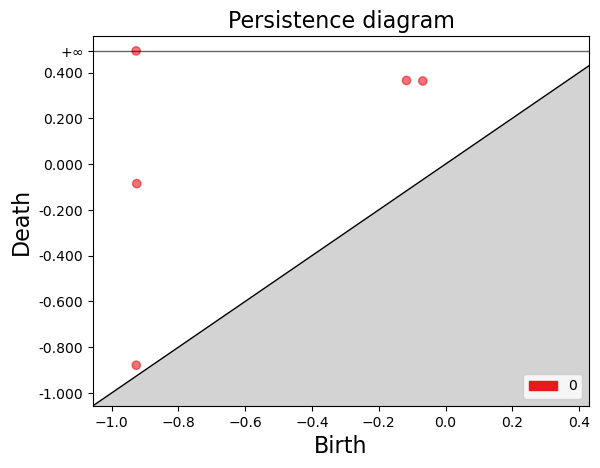

In [6]:
filtration=tf.Variable(initial_value=np.array([node['colors'] for node in list(mapper.node_info.values())],dtype=np.float32),trainable=True)
layer=LowerStarSimplexTreeLayer(simplextree=cplx, homology_dimensions=[0,1])
dgm=layer.call(filtration)
gd.plot_persistence_diagram(cplx.persistence(),legend=True);

## Optimization for 3D shapes

### Human

In [7]:
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.035629…

In [8]:
params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [129]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
mapper.fit(vertices)
G0=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G0)
nt.show('human_initial.html')

In [130]:
losses, dgms, regularizations = [], [], []

for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:
        f=tf.tensordot(X,params,axes=1)
        mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
        mapper.fit(vertices)
        layer = LowerStarSimplexTreeLayer(simplextree=mapper.simplex_tree, homology_dimensions=[0])
        indices=[node['indices'] for node in mapper.node_info.values()]
        f_values=[tf.reshape(tf.math.reduce_mean(tf.gather(f,ind)),(1,1)) for ind in indices]
        filtration=tf.concat(f_values,0)
        dgm = layer.call(filtration)[0][0]
        
        regularization = tf.math.square(tf.norm(params)-1)
        
        # Opposite of the squared distances to the diagonal 
        loss = -tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))+regularization
    gradients = tape.gradient(loss, [params])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    # np.random.seed(epoch)
    # gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [params]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    regularizations.append(regularization)

100%|█████████████████████████████████████████| 201/201 [02:37<00:00,  1.28it/s]


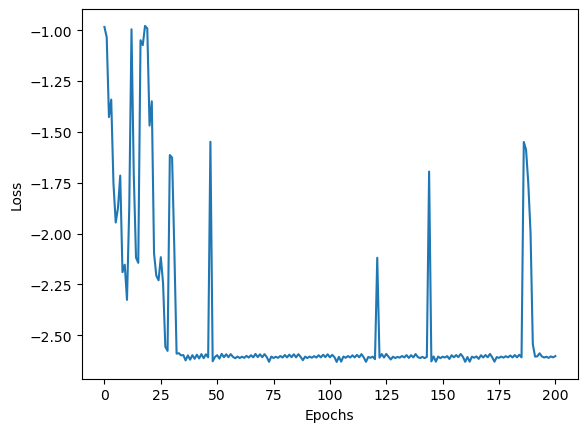

In [131]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

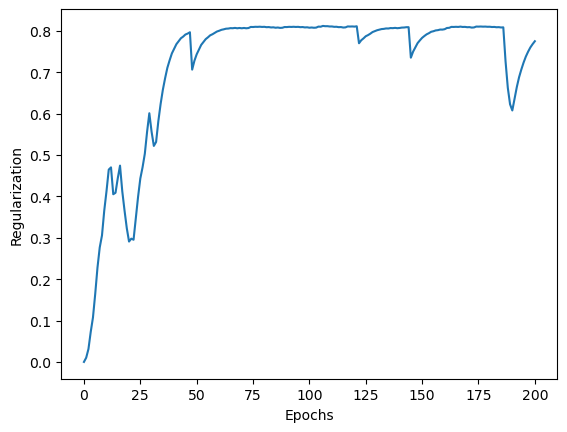

In [132]:
plt.figure()
plt.plot(regularizations)
plt.xlabel('Epochs')
plt.ylabel('Regularization')
plt.show()

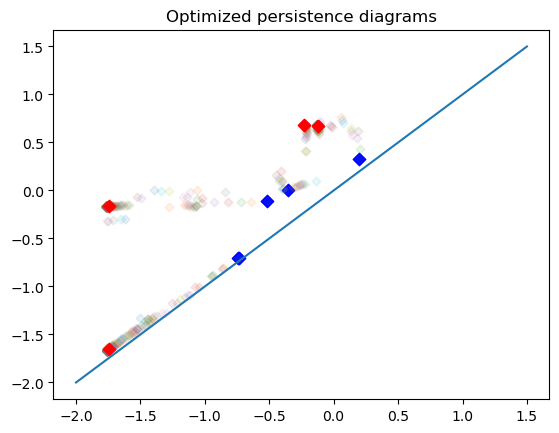

In [133]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-2,1.5], [-2,1.5])
plt.title('Optimized persistence diagrams')
plt.show()

In [134]:
print(params)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.10170916],
       [1.8804253 ],
       [0.01611199]], dtype=float32)>


In [135]:
G=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show('human_optimal.html')

### Octopus

In [9]:
path=r"/Users/ziyad/Desktop/LabeledDB_new/"
vertices, faces = off2numpy(path + 'Octopus/132.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0087004…

In [8]:
kmeans=KMeans(n_clusters=8)
n_intervals=np.array([10])
params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
mapper.fit(vertices)
G0=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G0)
nt.show('octopus_initial.html')

In [10]:
losses, dgms, regularizations = [], [], []

for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:
        f=tf.tensordot(X,params,axes=1)
        mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
        mapper.fit(vertices)
        layer = LowerStarSimplexTreeLayer(simplextree=mapper.simplex_tree, homology_dimensions=[0])
        indices=[node['indices'] for node in mapper.node_info.values()]
        f_values=[tf.reshape(tf.math.reduce_mean(tf.gather(f,ind)),(1,1)) for ind in indices]
        filtration=tf.concat(f_values,0)
        dgm = layer.call(filtration)[0][0]
        
        regularization = tf.math.square(tf.norm(params)-1)
        
        # Opposite of the squared distances to the diagonal 
        loss = -tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))+5*regularization
    gradients = tape.gradient(loss, [params])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    # np.random.seed(epoch)
    # gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [params]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    regularizations.append(regularization)

100%|█████████████████████████████████████████| 201/201 [02:40<00:00,  1.25it/s]


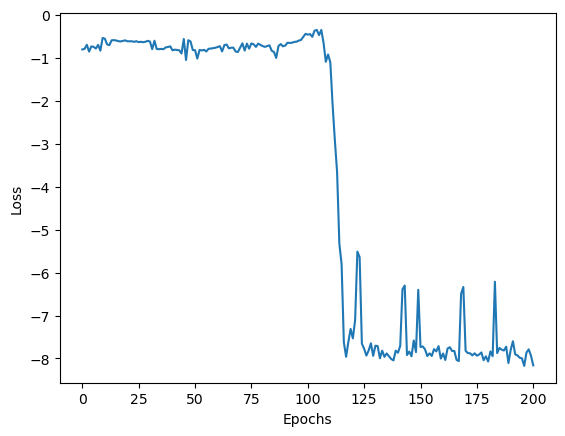

In [11]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

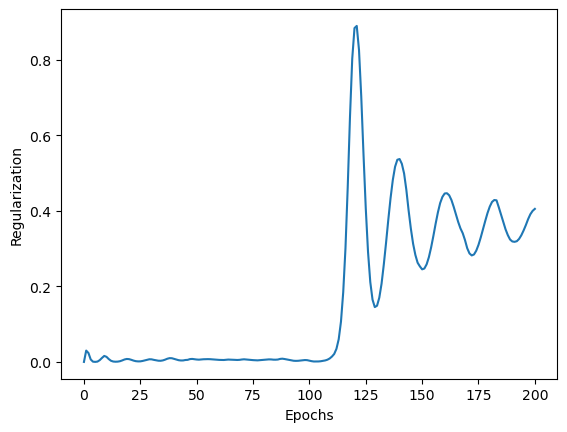

In [12]:
plt.figure()
plt.plot(regularizations)
plt.xlabel('Epochs')
plt.ylabel('Regularization')
plt.show()

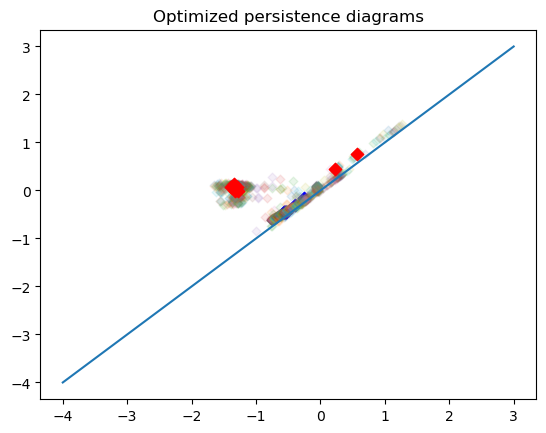

In [13]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-4,3], [-4,3])
plt.title('Optimized persistence diagrams')
plt.show()

In [14]:
print(params)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.09809945],
       [ 0.00576194],
       [-1.6358255 ]], dtype=float32)>


In [15]:
G=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show('octopus_optimal.html')

### Table

In [10]:
path=r"/Users/ziyad/Desktop/LabeledDB_new/"
vertices, faces = off2numpy(path + 'Table/150.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0016575…

In [68]:
kmeans=KMeans(n_clusters=3)
n_intervals=np.array([25])
params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [69]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
mapper.fit(vertices)
G0=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G0)
nt.show('table_initial.html')

In [70]:
losses, dgms, regularizations = [], [], []

for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:
        f=tf.tensordot(X,params,axes=1)
        mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
        mapper.fit(vertices)
        layer = LowerStarSimplexTreeLayer(simplextree=mapper.simplex_tree, homology_dimensions=[0])
        indices=[node['indices'] for node in mapper.node_info.values()]
        f_values=[tf.reshape(tf.math.reduce_mean(tf.gather(f,ind)),(1,1)) for ind in indices]
        filtration=tf.concat(f_values,0)
        dgm = layer.call(filtration)[0][0]
        
        regularization = tf.math.square(tf.norm(params)-1)
        
        # Opposite of the squared distances to the diagonal 
        loss = -tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))+5*regularization
    gradients = tape.gradient(loss, [params])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    # np.random.seed(epoch)
    # gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [params]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    regularizations.append(regularization)

100%|█████████████████████████████████████████| 201/201 [17:13<00:00,  5.14s/it]


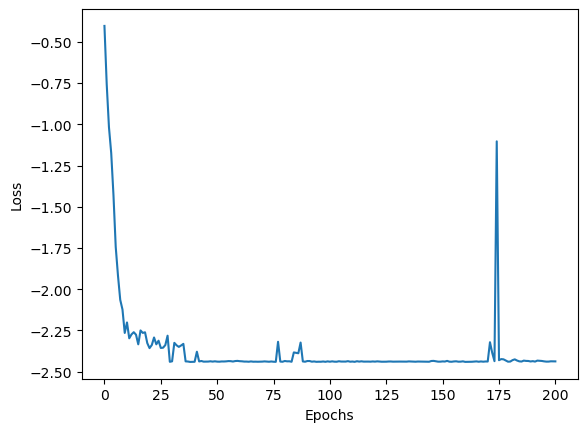

In [71]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

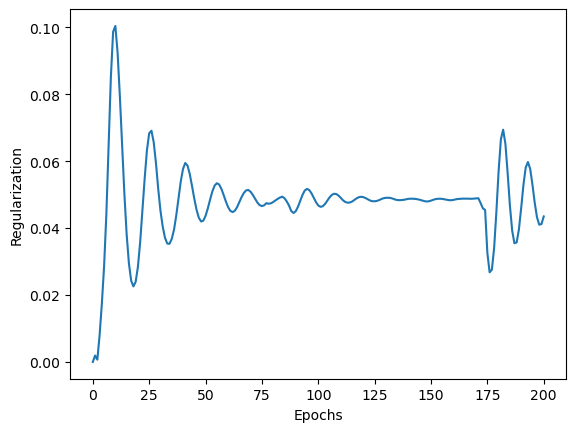

In [72]:
plt.figure()
plt.plot(regularizations)
plt.xlabel('Epochs')
plt.ylabel('Regularization')
plt.show()

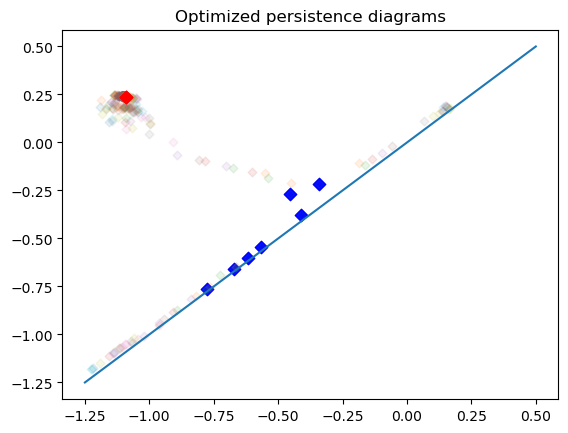

In [76]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1.25,0.5], [-1.25,0.5])
plt.title('Optimized persistence diagrams')
plt.show()

In [77]:
print(params)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.01481393],
       [ 1.2168273 ],
       [ 0.02394951]], dtype=float32)>


In [78]:
G=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show('table_optimal.html')

## Optimization for genomic data 

### Data

In [7]:
files = []
cells = []
libs = []
days = []
with open(r'/Users/ziyad/Downloads/scTDA Tutorial/data.txt', 'r') as f:
    for line in f:
        sp = line[:-1].split('\t')
        files.append(sp[0])
        cells.append(int(sp[1]))
        libs.append(sp[2])
        days.append(int(sp[3]))

In [8]:
time=[]
dfs=[]
for i in range(len(files)):
    f=files[i]
    dfs.append(pd.read_csv(r"/Users/ziyad/Downloads/scTDA Tutorial/"+f,sep="\t",header=None,index_col=0))
    time=time+[days[i]]*dfs[i].shape[1]
df=(pd.concat(dfs,axis=1)).transpose()

In [9]:
df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ERCC-00077,ERCC-00069,ERCC-00137,ERCC-00013,ERCC-00168,ERCC-00041,ERCC-00081,ERCC-00086,ERCC-00061,ERCC-00048
1,0,0,0,0,0,0,0,0,1,0,...,0,0,7,0,1,0,0,0,0,1
2,22,0,0,0,0,3,0,0,19,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,269,0,...,1,0,5,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,150,0,...,1,0,9,0,0,0,0,3,0,1
5,0,0,18,0,0,231,0,0,290,0,...,1,0,5,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0,0,0,0,0,0,0,0,1086,0,...,0,0,2,0,0,0,0,0,0,0
7,21,0,0,0,0,14,0,0,485,0,...,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,581,0,...,0,0,0,0,0,0,0,0,0,0
9,14,0,1,0,0,0,0,11,401,0,...,3,0,2,0,0,0,0,0,0,0


### PCA

In [10]:
sc=StandardScaler()
X=sc.fit_transform(df)

In [11]:
pca=PCA(n_components=10)
p_directions=pca.fit_transform(X)

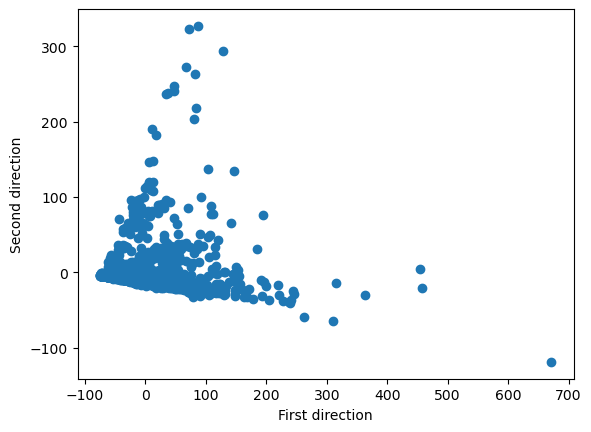

In [12]:
plt.figure()
plt.scatter(p_directions[:,0],p_directions[:,1])
plt.xlabel('First direction')
plt.ylabel('Second direction')
plt.show()

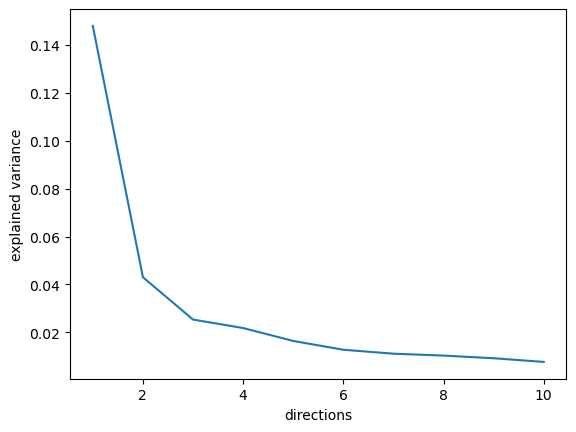

In [13]:
var=pca.explained_variance_ratio_
plt.figure()
plt.plot(np.array(range(len(var)))+1,var)
plt.xlabel('directions')
plt.ylabel('explained variance')
plt.show()

### Mapper optimization

In [41]:
params=tf.Variable(initial_value=np.ones(3,np.float32).reshape((3,1)),trainable=True)
Y=tf.Variable(initial_value=p_directions[:,0:3].astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [42]:
n_clusters=3
n_intervals=np.array([25])
gain=np.array([0.3])
kmeans=KMeans(n_clusters=n_clusters)

f=tf.tensordot(Y,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
mapper.fit(X)
G0=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G0)
nt.show('genomics_initial.html')

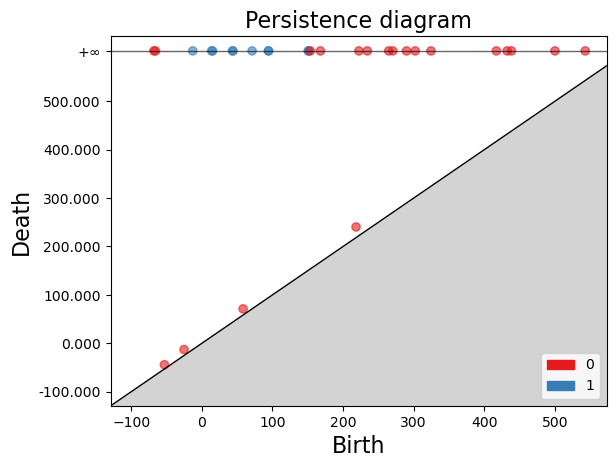

In [43]:
cplx=mapper.simplex_tree
filtration=tf.Variable(initial_value=np.array([node['colors'] for node in list(mapper.node_info.values())],dtype=np.float32),trainable=True)
layer=LowerStarSimplexTreeLayer(simplextree=cplx, homology_dimensions=[0,1])
dgm=layer.call(filtration)

gd.plot_persistence_diagram(cplx.persistence(persistence_dim_max=True),legend=True);

In [44]:
losses, dgms0, dgms1, regularizations = [], [], [], []

for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:
        f=tf.tensordot(Y,params,axes=1)
        mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=n_intervals, gains=gain, clustering=kmeans)
        mapper.fit(X)
        layer = LowerStarSimplexTreeLayer(simplextree=mapper.simplex_tree, homology_dimensions=[0,1])
        indices=[node['indices'] for node in mapper.node_info.values()]
        f_values=[tf.reshape(tf.math.reduce_mean(tf.gather(f,ind)),(1,1)) for ind in indices]
        filtration=tf.concat(f_values,0)
        dgm=layer.call(filtration)
        dgm0 = dgm[0][0]
        dgm1 = dgm[1][1]
        regularization = tf.math.square(tf.norm(params)-1)
        # Opposite of the squared distances to the diagonal 
        loss = -tf.math.reduce_sum(tf.math.abs((dgm0[:,1]-dgm0[:,0]
                                               )))-tf.math.reduce_sum(dgm1)+regularization
    
    gradients = tape.gradient(loss, [params])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    # np.random.seed(epoch)
    # gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [params]))
    losses.append(loss.numpy())
    dgms0.append(dgm0)
    dgms1.append(dgm1)
    regularizations.append(regularization)

100%|█████████████████████████████████████████| 201/201 [17:33<00:00,  5.24s/it]


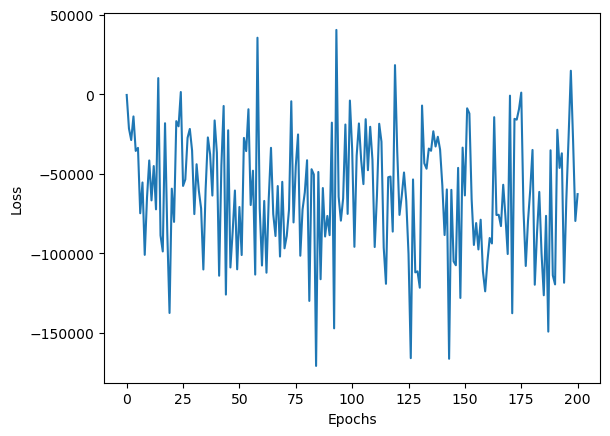

In [45]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

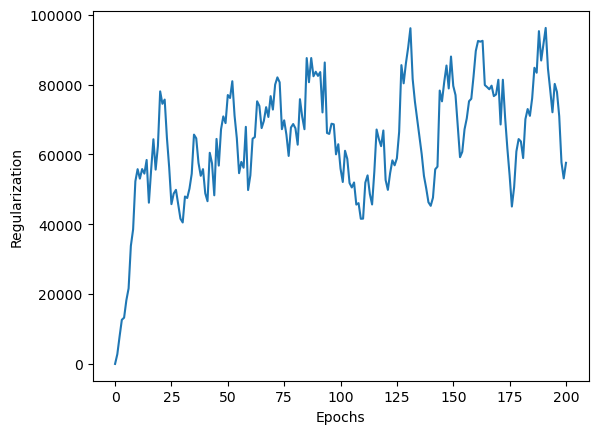

In [46]:
plt.figure()
plt.plot(regularizations)
plt.xlabel('Epochs')
plt.ylabel('Regularization')
plt.show()

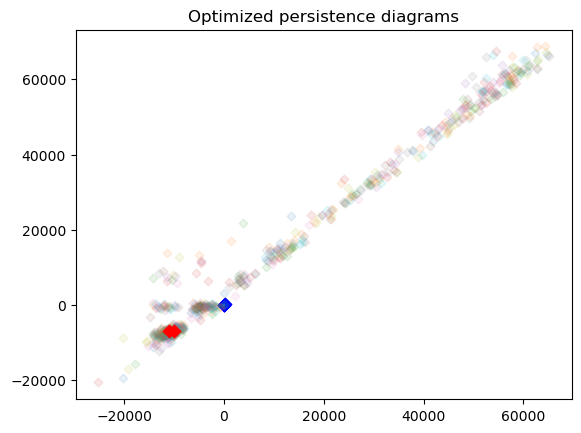

In [47]:
plt.figure()
plt.scatter(dgms0[0][:,0], dgms0[0][:,1], s=40, marker='D', c='blue')
for dg in dgms0[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms0[-1][:,0], dgms0[-1][:,1], s=40, marker='D', c='red')
plt.plot([-2,1.5], [-2,1.5])
plt.title('Optimized persistence diagrams')
plt.show()

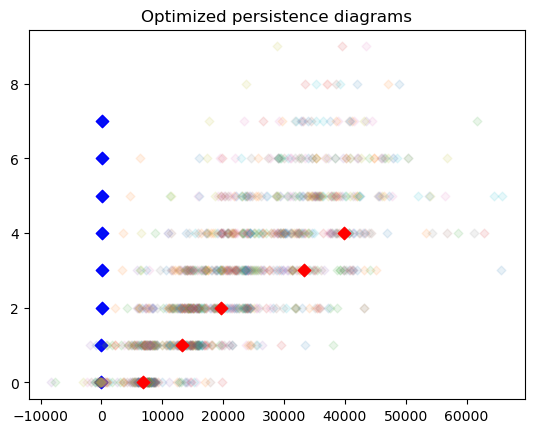

In [56]:
plt.figure()
plt.scatter(dgms1[0], range(len(dgms1[0])),s=40, marker='D', c='blue')
for dg in dgms1[:-1]:
    plt.scatter(dg, range(len(dg)),s=20, marker='D', alpha=0.1)
plt.scatter(dgms1[-1], range(len(dgms1[-1])), s=40, marker='D', c='red')
#plt.plot([-2,1.5], [-2,1.5])
plt.title('Optimized persistence diagrams')
plt.show()

In [49]:
print(params)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[231.87401 ],
       [ -1.314277],
       [-72.03438 ]], dtype=float32)>


In [57]:
G=mapper.get_networkx(get_attrs=True)
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show('genomics_optimal.html')